## S2 To R1 Attractor, S2 Damping - Geometric Consistency Test (RMPflow)

In [1]:
using PBDS, StaticArrays, LinearAlgebra, BenchmarkTools

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-4033640416287950141\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-15305491010088574624\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-4033640416287950141\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## Setup

### Point Distance Attractor

In [2]:
PBDS.task_map_emb(::EmbRep, ::EmbRep, xme, task_map::DistanceFromPoint{S2,R1}) where n =
    SA[norm(xme - task_map.position_center)]
PBDS.domain_coord_rep(::DistanceFromPoint{S2,R1,S}) where S = EmbRep()

PBDS.metric_chart(xn, vn, task::AttractorGDS{<:DistanceFromPointT{S2,R1,S}}, CN::Chart{1,R1}) where S = 
    default_metric(xn, vn, task, CN)
PBDS.potential_chart(xn, task::AttractorGDS{<:DistanceFromPointT{S2,R1,S}}, CN::Chart{1,R1}) where S = 
    xn[1].^2
PBDS.dissipative_term_chart(xn, vn, task::AttractorGDS{<:DistanceFromPointT{S2,R1,S}}, CN::Chart{1,R1}) where S = SMatrix{1,1,eltype(xn)}([0.])

### Sphere Damping

In [3]:
PBDS.default_coord_rep(::DampingGDS{<:IdentityT{S2,S2,S}}) where S = EmbRep()
function PBDS.metric_emb(xne, vne, task::DampingGDS{<:IdentityT{S2,S2,S}}) where S
    n = embdim(S2)
    U = promote_type(eltype(xne),eltype(vne))
    SMatrix{n,n,U}(I)
end
PBDS.potential_emb(xn, task::DampingGDS{<:IdentityT{S2,S2,S}}) where S = 0.
function PBDS.dissipative_term_emb(xne, vne, task::DampingGDS{<:IdentityT{S2,S2,S}}) where S
    n = embdim(S2)
    4*SMatrix{n,n,eltype(xne)}(I)
end
PBDS.home_task_chart(task::DampingGDS{<:IdentityT{S2,S2,S}}) where S = Chart{SterProjSouth,S2}()

In [4]:
M = S2
tasks, CNs = TaskGDSList(), ChartList()

N = R1
CN = Chart{1,N}()
center = SA[1., -1., -1.]
center = center ./ norm(center)
push!(tasks, AttractorGDS(DistanceFromPointT{M,N}(center)))
push!(CNs, CN)

N = S2
CN = Chart{SterProjSouth,S2}()
push!(tasks, DampingGDS(IdentityT{M,N,Float64}()))
push!(CNs, CN)

2-element Array{Chart,1}:
 Chart{1,ℝ{1}}()
 Chart{SterProjSouth,𝕊{2}}()

## Point Acceleration

In [5]:
# Initial state
xme = SA[-1., 1., 1.]
xme = xme ./ norm(xme)
vme = SA[2., 1., 1.]
robot_coord_rep = EmbRep()

CM = Chart{SterProjNorth,S2}()
PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) = Chart{SterProjNorth,S2}()
σxddot, = multiple_task_acceleration(xme, vme, tasks, CM, CNs, robot_coord_rep)

([2.1631165442257956, 0.510223619334091, -8.739411920521555], Chart[])

In [6]:
CM = Chart{SterProjSouth,S2}()
PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) = Chart{SterProjSouth,S2}()
σxddot, = multiple_task_acceleration(xme, vme, tasks, CM, CNs, robot_coord_rep)

([3.2681819070291835, -5.86967613169664, -1.2544468066874375], Chart[])

## Single Trajectory

In [7]:
using Plots, Makie, Observables, ProgressMeter

In [8]:
Time = 15
dt = 0.01

PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) = Chart{SterProjNorth,S2}()
traj_north = propagate_tasks(xme, vme, tasks, CM, CNs, Time, dt, robot_coord_rep, log_tasks = true)

PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) = Chart{SterProjSouth,S2}()
traj_south = propagate_tasks(xme, vme, tasks, CM, CNs, Time, dt, robot_coord_rep, log_tasks = true)

PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) =
    (pe[3] < 0)[1] ? Chart{SterProjSouth,S2}() : Chart{SterProjNorth,S2}()
traj_switching = propagate_tasks(xme, vme, tasks, CM, CNs, Time, dt, robot_coord_rep, log_tasks = true)
traj_switching.xm[end]

3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
  0.5774634636956892
 -0.5790680865107488
 -0.5755137698451335

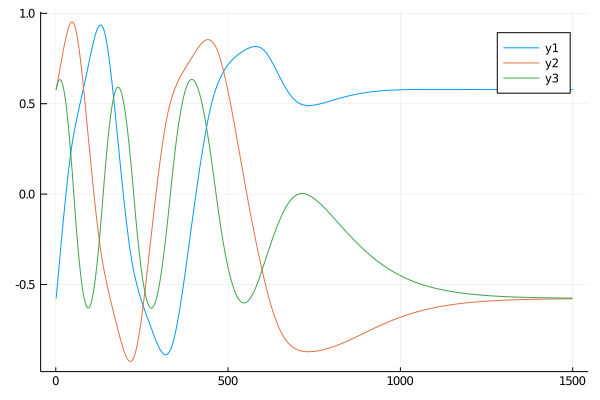

In [9]:
Nplot = length(traj_switching.xm)
Plots.plot(getindex.(traj_switching.xm,1)[1:Nplot])
Plots.plot!(getindex.(traj_switching.xm,2)[1:Nplot])
Plots.plot!(getindex.(traj_switching.xm,3)[1:Nplot])

In [10]:
AbstractPlotting.__init__()
Makie.AbstractPlotting.inline!(false)
ax_size, plot_size = 1, 800
limits = FRect3D((-ax_size, -ax_size, -ax_size), (2*ax_size, 2*ax_size, 2*ax_size))
scene = Scene(resolution = (plot_size, plot_size))
mesh!(Sphere(Point3f0(zeros(3)), 1.), color = RGBA(1.,1.,1.,0.4), transparency = true)
Makie.scatter!(scene, [xme[1]], [xme[2]], [xme[3]], markersize = ax_size/20, color = :blue, limits = limits)
δ = 0.99
Makie.scatter!(scene, [center[1]*δ], [center[2]*δ], [center[3]*δ], markersize = ax_size/20, color = :green, limits = limits)

linewidth = 1.5
Makie.lines!(scene, getindex.(traj_switching.xm,1), getindex.(traj_switching.xm,2), getindex.(traj_switching.xm,3), color = :purple, linewidth = linewidth)
Makie.lines!(scene, getindex.(traj_south.xm,1), getindex.(traj_south.xm,2), getindex.(traj_south.xm,3), color = :red, linewidth = linewidth)
Makie.lines!(scene, getindex.(traj_north.xm,1), getindex.(traj_north.xm,2), getindex.(traj_north.xm,3), color = :blue, linewidth = linewidth)

Makie.xlabel!(scene, "x")
Makie.ylabel!(scene, "y")
axis = scene[Axis]
axis.showaxis = false
rotate_cam!(scene, 0.4, 0., 0.)
display(scene)

GLMakie.Screen(...)

## Animation

In [11]:
iobs = Observable(1)
AbstractPlotting.__init__()
Makie.AbstractPlotting.inline!(false)
ax_size, plot_size = 1, 800
limits = FRect3D((-ax_size, -ax_size, -ax_size), (2*ax_size, 2*ax_size, 2*ax_size))
scene = Scene(resolution = (plot_size, plot_size))
mesh!(Sphere(Point3f0(zeros(3)), 1.), color = RGBA(1.,1.,1.,0.4), transparency = true)
δ = 1
Makie.scatter!(scene, [center[1]*δ], [center[2]*δ], [center[3]*δ], markersize = ax_size/20, color = :green, limits = limits)

accel_rate = 2
Makie.scatter!(scene, lift(i -> [traj_switching.xm[(i-1)*accel_rate+1][1]], iobs), lift(i -> [traj_switching.xm[(i-1)*accel_rate+1][2]], iobs), lift(i -> [traj_switching.xm[(i-1)*accel_rate+1][3]], iobs), markersize = ax_size/20, color = :purple, limits = limits)
Makie.scatter!(scene, lift(i -> [traj_south.xm[(i-1)*accel_rate+1][1]], iobs), lift(i -> [traj_south.xm[(i-1)*accel_rate+1][2]], iobs), lift(i -> [traj_south.xm[(i-1)*accel_rate+1][3]], iobs), markersize = ax_size/20, color = :red, limits = limits)
Makie.scatter!(scene, lift(i -> [traj_north.xm[(i-1)*accel_rate+1][1]], iobs), lift(i -> [traj_north.xm[(i-1)*accel_rate+1][2]], iobs), lift(i -> [traj_north.xm[(i-1)*accel_rate+1][3]], iobs), markersize = ax_size/20, color = :blue, limits = limits)

linewidth = 2.5
Makie.lines!(scene, getindex.(traj_switching.xm,1), getindex.(traj_switching.xm,2), getindex.(traj_switching.xm,3), color = :purple, linewidth = linewidth)
Makie.lines!(scene, getindex.(traj_south.xm,1), getindex.(traj_south.xm,2), getindex.(traj_south.xm,3), color = :red, linewidth = linewidth)
Makie.lines!(scene, getindex.(traj_north.xm,1), getindex.(traj_north.xm,2), getindex.(traj_north.xm,3), color = :blue, linewidth = linewidth)

Makie.xlabel!(scene, "x")
Makie.ylabel!(scene, "y")
axis = scene[Axis]
axis.showaxis = false
rotate_cam!(scene, 0.4, 0., 0.)
display(scene)

GLMakie.Screen(...)

In [12]:
function record_scene(scene, filename, iobs, N, framerate=60)
    p = Progress(N)
    record(scene, filename, 1:N) do i
        iobs[] = i
        rotate_cam!(scene, 0.01, 0., 0.)
        next!(p)
    end
    display("text/html", html_video(filename))
end

filename = "S2_To_R1Attractor_S2Damping_ConsistencyTest.mp4"
record_scene(scene, filename, iobs, Int(floor(length(traj_north.xm)/accel_rate)))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQBDNJltZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjQgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAIESZYiEACv//vbw/gU2O5jQlxHN6J0zH78VuLo0N73OAAFn+wAAAwAAAwATL8CrmYA0J8xwAAADACPgBkwGsAyl+p8DtegNTNXdhxktLhJAOcurqT3V8p33KkQ+/PlFghmc5dul/wpOzkFgCOlu2cwdUV+M37A+tndeJrKCeTJCDHThOFh6iuODYt6m6/JK3lLoZmyArIGmGBgdU2r+6K+Tk9RE8qew1p5+ENx9h1pOhNrtR/ThKIA+SgIAPbdULJLZ7IvGzN3QQf97hLAq2EGVylYDzz2raQrz9KYTKXxXUNMr2wYIwSGsGYbn6Iqykvi3SShz+5AGtlkTil5LvvrUGIjfhTJ4jENKewPDw/uRJCM90ObCsjbjvVIusqXv4XK5+PBdCnegVdFpkMDE1lMKpI5tOXUTK3hLqpXIGL3hW8vFS4wXYWf9hJEP07Y1Xi+fP+JjpBZAsKvpPPctjRIy17TwCseIx+6QaWYAOX+F6o9SZgwO56DN5FKE2VS0AVQnPPafrpn9HA3lASKZEjrrOep7rRdxuRudZZcYHSF2HsT65R2f45k6daDHMazlGqSqn+lj6vD9pwaqqGXaGYUiAhtWmllMVxczEek7R1kiPPrYJ9+YTcSUs8EcyX2Aa1QYUIF+CM/ui3FPhQd5jGrv3KGwkhkWlk8EnwlS+uTBcrt8tITMm/vkZCc1mLDQLNb6Ar3buPNWiZgbVFELPEND8mBd82oWO4gHmKIsA3IKaeouX3bardrAe1RbTvrY8xJtNpN2dYXffczMBf7NbOUTuvrZ7UrsdWSWCurMRi20lXrLUjiRebPPjfBiqI65ho2T9kIU4QDQupLvWO745aR08HX3U0HUE6kcrx6VrhX+E8DsqV4OyprzbGqv8ovOhA/aD2gUUpFk6fkIUwVngfdZf2W5Edcs2PCZlNiOQ5rG5X5iE20ALO2B5tKtX9IReOfyy4y7RyL0gmqNEiW41aOTqhNoqx9AcbgwFYdSQQuzD1V7rroJE90xz1Dmn50FNxjahRVwO1hc2jn3feMKOsfJ3G+08PZ6e0bw8q72MLXOw3AqubC/q8UAt8riiZdLj97hV6uHPtLNIIE3VJTqPed0Pqx4X5V+uhUmFijofsyPDF6iBQlUOOwC36gqQyy/PuXXowI+m4Gu2r5HzigsGU1PEyCGNc+DxgZ3ihsrYJvxzFr7qQ6gdZNveaHs/mzkz9V/D8PDEe5injR+BPCagOl+dQI3qOdL8RQRFHrgxV1ALrLh48YrAFwgh9/v8OeLLgNAjhwzKofSXSHKqtE676en9XPV4MAdD7nCnzoZijBm998nC737JefjV9DIKzEAKpqn7Ov/X7niXCi/3VnQfy93wDRGpd8yLirQFjrQ7oBs47zpSppMcAyRd4d6jyOIxSnwfetXNQYFT0KOgD70v+iYqIws5mrN6D61NXKGr8VfrjULWNhxYmKJFNXEmmnC9CSjo+g/lL2gN3jm/2+aYRvR5SCRVRo9f8Jga09rzZsA882+/DxjlRkZAoKwhDp6jVxT9Y/13LKjwnmoGLqyVH7b62oOz8jsMR1baC4yAP3yG9/gPmOMUTEwRoDHf8jXmFvnuBL7daDs0A3unQbqyya1AFTb3putpeAGtJTVTUijVwd3LiYoolTTEN7H0X+RXZIb3k61BvDEwyHsZrtgsEZQnSlXlgeCo1aVzyNtEdFEom8V/mZ0h2HTvgD1DpDkEHZGn5rj+n1s9xdwBEW1mKNVaptvQifiSjWySJtbFPaDyx6fFx+SYYLC3e30HMAKhC0+8ZBjuL+9h8ZALgEo+XirIJoMJc2O+XAw7+2kV6qcFnX8OAjHSUcY7ovpVth2P4dte5XOW6/yzq3bB+Dm2d5/3sLxIwXBt1PrTlmqh/FYxUzhN34FKw49FwKafZNH6ShWz5cDYOTOTS+FZK6EzOJI4i8c2BbO/vpMYja6U3FpPAtdAfd0cRZNbzCVCR9a7FisNgkeewuFM+Caxxpyqxf69Z67/NTj7DsxY6KlfqF+7YjZvKsh0v5CCBjt+2vMN88eYKRghgMBF6KaX4LonIU9qUpDWbmlIG/t8/CicpePC8qwUMHI6/wOP5+BLx3wXtB53llEECbO8WQsfnqa+UbfHQv0KieTXDXQTcbCcrQp0ufQOsaTzUu3AINfg77s2XSvUeOZFIuQeGBJ99qsgpRQsElshKmGeEPYnACB8PGnDu+st+GJAmR9YgYYdAjnU+Rf6OdXT77hbWZvLJvG/D3vgEngo7DkBspMNcKc3Y18svdGfMUZn5yI3kT9wbXbkinJHTOnBdbdOTgpWkC+W2f9QphFpYaRYZvMAAqofs9Yn69xq7/G3n7b9e/OxluhOlgZvgIgEch8jcKQxtpce3+QE7nS/XQN1dYdu9/v++eBcJtyDx1vYqN5np5lZa/5u6ByULlsuE60FksIxnijoNHevGBR8uRwFV/+oUKUWV/vn4Dr6bkU4/DNHXJJSR5S64OaFkXHxyFp94+r37l/2q+F3LI/CjT5RQMVleWChTsgRMLsoNhG2cO/T+jR0ZywALRvh2TSp8cEhUfVhU4sfcg4vB7IVQFzgwqzAku+VFi9Y69MKku8RgWjFqA8Lg6yxhpqLN7Pr8Oem5XwcMaoOJyxwuq6yaBXddk9oVZ8bO5ld1v6XBoMH6OmtzG7dOdDukkxkW4uykwefJ7Qn3d+hJ/eh9Mna/IrkKv3PtKWbfHnbc8SxtPao1YkjTQagelHM1nR5VNrcin+tR6GC0C62cM7y0fEWCVFtbnQT1Y2TJ2NL3k6trJAPrKjqWde8kUKbvJydgpWvUZ4KEAACnKb9bt+QR1aZVJaJYhKJ96I1fDclnt6qgyPGHFPpXN/UI0mDhUYLZ+ZaQLMhQ80hZ4USj1pYKUYa1aj9teuX3J/7FAaU82fd7Z3WjDRX4XYrElveW3KHK5/jIudD8LZyoPxTVFYC58nnO4yqycx5P79cLx